# Data preprocessing
This script fetches and processes data from a user's anime list on MyAnimeList

In [120]:
import requests
import pandas as pd
import configparser


config = configparser.ConfigParser()
config.read('config.ini')
USER_NAME = config.get('USER', 'USER_NAME').strip()
CLIENT_ID = config.get('USER', 'CLIENT_ID').strip()


# Constructing the URL for API request using USER_NAME
# TODO interface for different user names
url = f'https://api.myanimelist.net/v2/users/{USER_NAME}/animelist'
# url = f'https://api.myanimelist.net/v2/users/kemmy22/animelist'

# Setting headers for the API request, including the CLIENT_ID
headers = {
    'X-MAL-CLIENT-ID': CLIENT_ID
}

# Setting parameters for the API to specify limit and fields
params = {
    'limit': 2000,
    'fields': 'list_status{score},alternative_titles{en},mean,genres,popularity',
    'status': 'completed'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    # Parsing the JSON response into Python dictionary
    anime_data = response.json()
    
    modified_anime_data = []
    
    # Iterating through each anime entry in the API response to get all the info
    for anime in anime_data['data']:
        anime_info = anime['node']  # Extracting anime info
        list_status = anime.get('list_status', {})  # Extracting list status - anime score
        
        # Creating a modified anime entry with selected attributes
        modified_anime = {
            'user_score': list_status.get('score'),
            'title': anime_info.get('alternative_titles', {}).get('en'),
            'mal_score': anime_info.get('mean'),
            'genres': [genre['name'] for genre in anime_info.get('genres', [])],
            'popularity': anime_info.get('popularity')
        }
        
        modified_anime_data.append(modified_anime)
    
    
    # Creating a DataFrame
    df = pd.DataFrame(modified_anime_data)
    print(df.head(2))
    
    # Saving anime list
    csv_file_path = './data/anime_list.csv'
    df.to_csv(csv_file_path, index=False, encoding='utf-8')

    print(f"Data successfully written to '{csv_file_path}'")
else:
    print(f"Failed to retrieve data: {response.status_code}")

Failed to retrieve data: 400


In [121]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras import regularizers
import numpy as np


df = pd.read_csv('./data/anime_list.csv')
# Loading the pre-trained Word2Vec model
word_vectors = Word2Vec.load('./models/anime_word2vec_model_updated')

df.columns = df.columns.astype(str)
# Handling missing values
df['title'] = df['title'].fillna('')
df['mal_score'] = df['mal_score'].fillna(df['mal_score'].mean())
df['popularity'] = df['popularity'].fillna(df['popularity'].mean())
df['user_score'] = df['user_score'].fillna(df['user_score'].mean())
df['genres'] = df['genres'].fillna('Unknown')

In [122]:
print(df.isnull().sum())

user_score    0
title         0
mal_score     0
genres        0
popularity    0
dtype: int64


In [123]:
# Function to convert anime titles into vectors using the Word2Vec model
def title_to_vector(anime_title):
    # Getting the vector size from the model
    vector_size = word_vectors.vector_size
    # Initializing the vector with zeros
    vector = np.zeros(vector_size)
    # Split the title into individual words
    words = str(anime_title).split()
    word_count = 0
    for word in words:
        # Checking if the word exists in the Word2Vec vocabulary
        if word in word_vectors.wv:
            vector += word_vectors.wv[word]
            word_count += 1
    # Returning the average vector or a zero vector if no words found
    return vector / word_count if word_count > 0 else vector

df['title_vector'] = df['title'].apply(title_to_vector)

# Converting the title_vector column into separate columns for each vector component
title_vectors = pd.DataFrame(df['title_vector'].tolist(), index=df.index)
df = pd.concat([df, title_vectors], axis=1).drop(['title_vector', 'title'], axis=1)


# One-hot encoding the genres column
genres_encoder = OneHotEncoder(sparse_output=False)
genres_encoded = genres_encoder.fit_transform(df[['genres']])
genres_encoded_df = pd.DataFrame(genres_encoded, columns=genres_encoder.get_feature_names_out(['genres']))
df = pd.concat([df, genres_encoded_df], axis=1).drop('genres', axis=1)


# Ensuring all column names are strings
df.columns = df.columns.astype(str)


# Normalizing numerical data using StandardScaler
numerical_columns = ['mal_score',  'popularity', 'user_score']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


# Defining the target variable Y and features X
Y = df['user_score']
X = df.drop(['user_score'], axis=1)
# X = X.dropna()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [124]:
print(X.isnull().sum())

mal_score                                      0
popularity                                     0
0                                              0
1                                              0
2                                              0
                                              ..
genres_['Seinen', 'Slice of Life']             0
genres_['Shounen', 'Sports', 'Team Sports']    0
genres_['Slice of Life']                       0
genres_['Sports', 'Team Sports']               0
genres_['Sports']                              0
Length: 714, dtype: int64


# Algorithms

## Support Vector Regression

Support Vector Machine” (SVM) is a supervised learning machine learning algorithm that can be used for both classification or regression challenges.

Unlike SVMs used for classification tasks, SVR Model seeks a hyperplane that best fits the data points in a continuous space. This is achieved by mapping the input variables to a high-dimensional feature space and finding the hyperplane that maximizes the margin (distance) between the hyperplane and the closest data points, while also minimizing the prediction error.


In [125]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train an SVM model with RBF kernel
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svm_model.predict(X_test)

# Evaluate the model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Mean absolute error: {mae_svr:.2f}")
print(f"Mean squared error: {mse_svr:.2f}")


Mean absolute error: 0.66
Mean squared error: 0.72


## Linear Regression

 Linear regression is a model that estimates the linear relationship between a scalar response (dependent variable) and one or more explanatory variables (regressor or independent variable)

In [126]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean absolute error: {mae:.2f}")
print(f"Mean squared error: {mse:.2f}")

Mean absolute error: 357239257428.10
Mean squared error: 1113072882534730984062976.00


## Decision Tree

A decision tree, which has a hierarchical structure made up of root, branches, internal, and leaf nodes, is a non-parametric supervised learning approach used for classification and regression applications.

Starting at the Root -> Asking the Best Questions -> Branching Out -> Repeating the Process

In [127]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_dt = regressor.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"Mean absolute error: {mae_dt:.2f}")
print(f"Mean squared error: {mse_dt:.2f}")

Mean absolute error: 0.70
Mean squared error: 0.90


## Random Forest

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that works by creating a multitude of decision trees during training. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the output is the average of the predictions of the trees.

In [128]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_rf = regressor.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean absolute error: {mae_rf:.2f}")
print(f"Mean squared error: {mse_rf:.2f}")

Mean absolute error: 0.60
Mean squared error: 0.67


## K Nearest Neighbors

KNN regression is a non-parametric method that approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.

In [129]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
regressor.fit(X_train, y_train)

y_pred_knn = regressor.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"Mean absolute error: {mae_knn:.2f}")
print(f"Mean squared error: {mse_knn:.2f}")

Mean absolute error: 0.64
Mean squared error: 0.71


## Gradient Boosting

Gradient Boosting is a powerful boosting algorithm that combines several weak learners into strong learners, in which each new model is trained to minimize the loss function such as mean squared error or cross-entropy of the previous model using gradient descent. In each iteration, the algorithm computes the gradient of the loss function with respect to the predictions of the current ensemble and then trains a new weak model to minimize this gradient. The predictions of the new model are then added to the ensemble, and the process is repeated until a stopping criterion is met.

In [130]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred_gb = regressor.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Mean absolute error: {mae_gb:.2f}")
print(f"Mean squared error: {mse_gb:.2f}")

Mean absolute error: 0.60
Mean squared error: 0.65


## Neural Network
This script performs data preprocessing and trains a neural network to predict user scores for anime titles

In [131]:
# Defining the neural network model architecture
# Number of input features
input_shape = X_train.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(input_shape,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compiling the model with optimizer, loss function, and evaluation metrics
model.compile(optimizer='sgd',
              loss='mse',  # Mean Squared Error
              metrics=['mae'])  # Mean Absolute Error

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the model on the test data
loss, mae_nn = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {mae_nn}')

Epoch 1/100


C:\Users\dobre\Documents\Code\Anime_Rating_Project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0768 - mae: 0.7854 - val_loss: 1.0773 - val_mae: 0.7699
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9317 - mae: 0.7129 - val_loss: 0.9559 - val_mae: 0.7033
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8545 - mae: 0.6825 - val_loss: 0.8746 - val_mae: 0.6513
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7517 - mae: 0.6125 - val_loss: 0.8245 - val_mae: 0.6184
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6712 - mae: 0.5713 - val_loss: 0.7971 - val_mae: 0.6036
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6473 - mae: 0.5594 - val_loss: 0.7868 - val_mae: 0.5945
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6389 - mae: 0.5579 - val_loss: 0.7842 - val_mae: 0.5889
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6709 - mae: 0.5527 - val_loss: 0.7807 - val_mae: 0.5841
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6548 - mae: 0.

# Visualizing

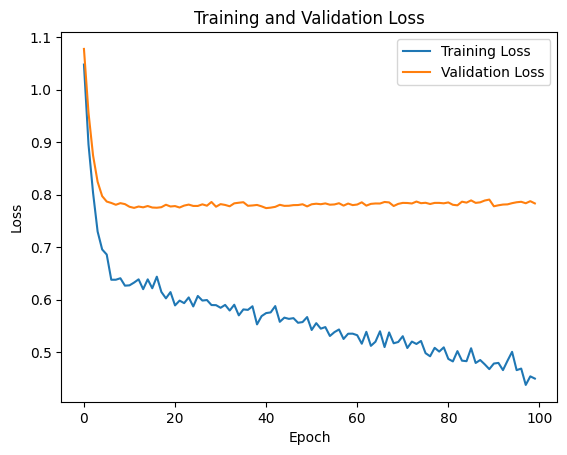

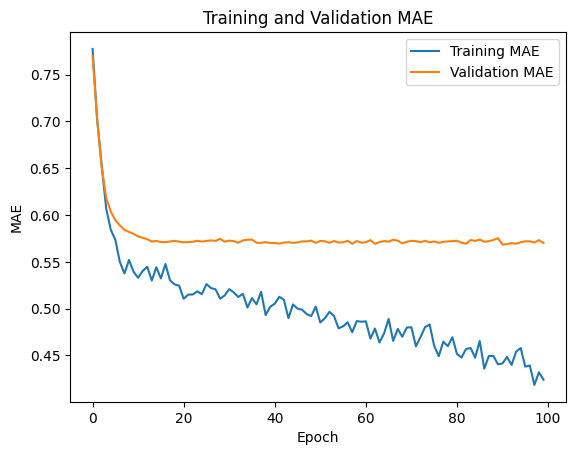

In [132]:
import matplotlib.pyplot as plt

# Getting the loss and metric values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting the training and validation loss over epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation MAE over epochs
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

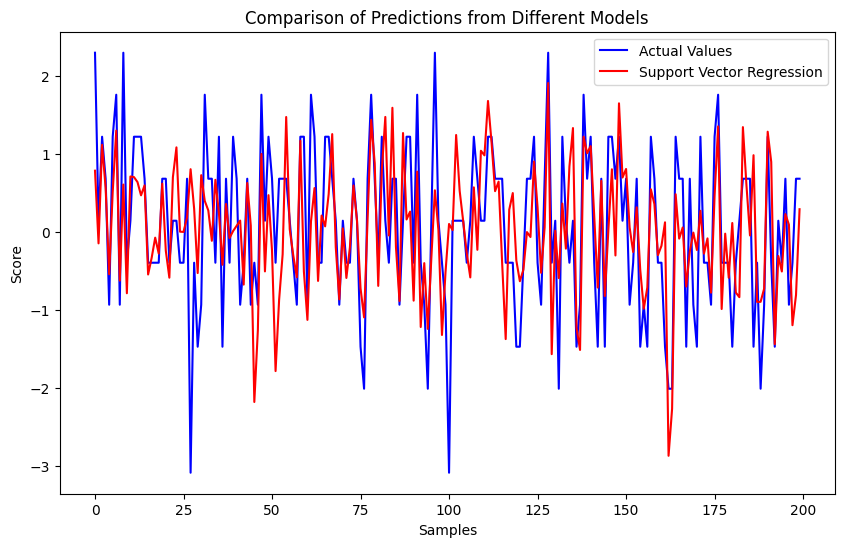

In [133]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_test)), y_pred_svr, label='Support Vector Regression', color='red')
# plt.plot(range(len(y_test)), y_pred_dt, label='Decision Tree', color='violet')
# plt.plot(range(len(y_test)), y_pred_rf, label='Random Forest', color='orange')
# plt.plot(range(len(y_test)), y_pred_knn, label='KNN', color='green')
# plt.plot(range(len(y_test)), y_pred_gb, label='Gradient Boosting Regressor', color='yellow')

plt.title('Comparison of Predictions from Different Models')
plt.xlabel('Samples')
plt.ylabel('Score')
plt.legend()
plt.show()


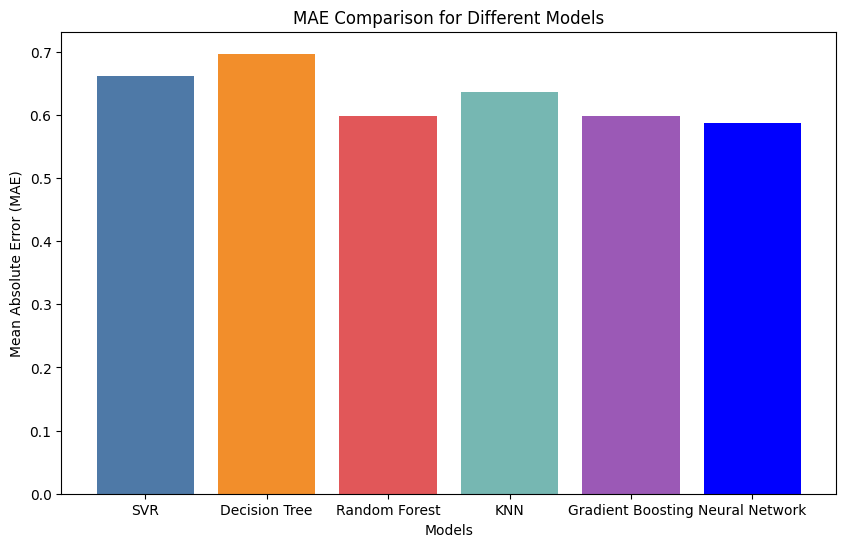

In [134]:
import numpy as np

models = ['SVR', 'Decision Tree', 'Random Forest', 'KNN', 'Gradient Boosting', 'Neural Network']
mae_values = [mae_svr, mae_dt, mae_rf, mae_knn, mae_gb, mae_nn]

plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#9B59B6', 'blue'])

plt.title('MAE Comparison for Different Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Models')
plt.show()

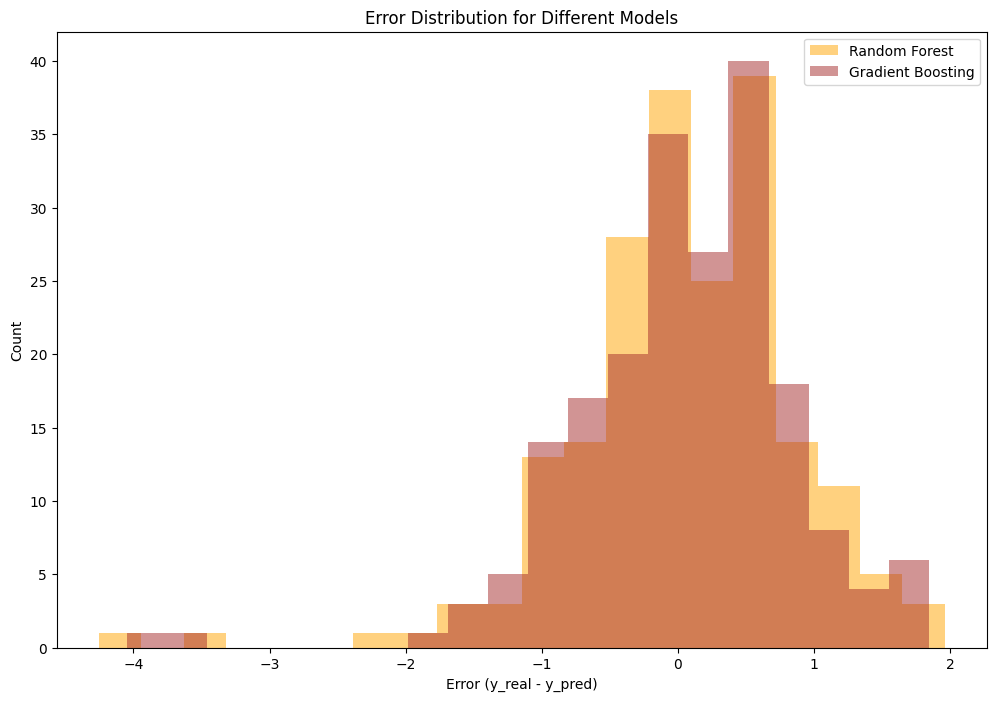

In [137]:
plt.figure(figsize=(12, 8))

# error_ for each model
errors_svr = y_test - y_pred_svr
errors_dt = y_test - y_pred_dt
errors_rf = y_test - y_pred_rf
errors_knn = y_test - y_pred_knn
errors_gb = y_test - y_pred_gb


# plt.hist(errors_svr, bins=20, alpha=0.5, label='SVR', color='red')
# plt.hist(errors_dt, bins=20, alpha=0.5, label='Decision Tree', color='blue')
plt.hist(errors_rf, bins=20, alpha=0.5, label='Random Forest', color='orange')
# plt.hist(errors_knn, bins=20, alpha=0.5, label='KNN', color='green')
plt.hist(errors_gb, bins=20, alpha=0.5, label='Gradient Boosting', color='brown')

plt.title('Error Distribution for Different Models')
plt.xlabel('Error (y_real - y_pred)')
plt.ylabel('Count')
plt.legend()
plt.show()


C:\Users\dobre\AppData\Local\Temp\ipykernel_22564\971480695.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(predictions.values(), labels=predictions.keys(), patch_artist=True,


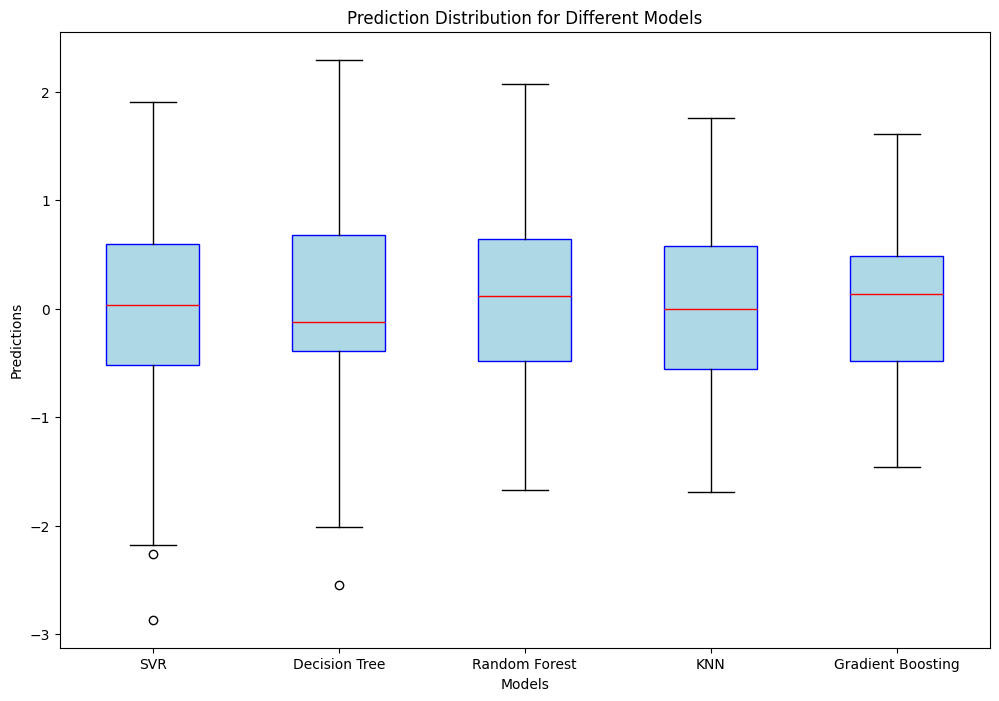

In [138]:
plt.figure(figsize=(12, 8))

predictions = {
    'SVR': y_pred_svr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'KNN': y_pred_knn,
    'Gradient Boosting': y_pred_gb
}

plt.boxplot(predictions.values(), labels=predictions.keys(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))

plt.title('Prediction Distribution for Different Models')
plt.ylabel('Predictions')
plt.xlabel('Models')
plt.show()